# hyperparameter tuning for `RandomForestClassifier`


In [4]:
import optuna

In [175]:
from sklearn.ensemble import RandomForestClassifier


import utils
import pandas as pd
from sklearn.metrics import roc_auc_score,f1_score,roc_curve,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [106]:
df = pd.read_csv('cleaned_data.csv')
(Xtrain,ytrain),(Xtest,ytest)=utils.get_train_test(df,'target',scale='standard')

In [176]:
def objective (trail):
    params={
      'n_estimators':trail.suggest_int('n_estimators',100,500),
      'max_depth':trail.suggest_int('max_depth',1,10),
      'min_samples_split':trail.suggest_int('min_samples_split',2,10),
      'min_samples_leaf':trail.suggest_int('min_samples_leaf',1,10),
      'max_features':trail.suggest_categorical('max_features',['sqrt','log2',None]),
      'bootstrap':trail.suggest_categorical('bootstrap',[True,False])

 }
    model=  RandomForestClassifier(**params ,random_state=42)
    model.fit(Xtrain,ytrain)
    proba=model.predict_proba(Xtest)[:,1]
    return roc_auc_score(ytest,proba)

In [177]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2025-11-02 21:48:09,680] A new study created in memory with name: no-name-d2f73eb3-c08a-4758-a6ae-f01a95b97917
[I 2025-11-02 21:48:09,893] Trial 0 finished with value: 0.9387061536594247 and parameters: {'n_estimators': 125, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.9387061536594247.
[I 2025-11-02 21:48:10,300] Trial 1 finished with value: 0.9322733341424929 and parameters: {'n_estimators': 286, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9387061536594247.
[I 2025-11-02 21:48:10,883] Trial 2 finished with value: 0.9254763927661123 and parameters: {'n_estimators': 359, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9387061536594247.
[I 2025-11-02 21:48:11,454] Trial 3 finished with value: 0.9336084476271392 

In [178]:
study.best_value

0.9463527127078529

In [184]:
result = study.trials_dataframe().drop(columns=['number','datetime_start', 'datetime_complete', 'duration','state'])

In [185]:
result.columns

Index(['value', 'params_bootstrap', 'params_max_depth', 'params_max_features',
       'params_min_samples_leaf', 'params_min_samples_split',
       'params_n_estimators'],
      dtype='object')

In [181]:
study.best_params

{'n_estimators': 278,
 'max_depth': 10,
 'min_samples_split': 7,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'bootstrap': False}

In [186]:
import altair as alt
alt.Chart(result).mark_point().encode(
    x=alt.X('params_n_estimators',)
    ,y='value'
)

alt.Chart(...)

for `n_estimators` >200 the model perform well


In [188]:
alt.Chart(result).mark_point().encode(
    x=alt.X('params_min_samples_split')
    ,y='value'
)

alt.Chart(...)

for min_samples_split > 7 the model perform well


In [183]:
alt.Chart(result).mark_point().encode(
    x='params_max_depth'
    ,y='value'
)

alt.Chart(...)

kernel rbf is the best for the model


In [189]:
import json
with open('best_params_rfc.json','w') as f:
    json.dump(study.best_params,f)

In [190]:
model=  RandomForestClassifier(random_state=42)
best=  RandomForestClassifier(**study.best_params ,random_state=42)


In [191]:
model.fit(Xtrain,ytrain)
best.fit(Xtrain,ytrain)


RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2,
                       min_samples_split=7, n_estimators=278, random_state=42)

In [192]:
proba_base = model.predict_proba(Xtest)[:,1]
proba_best = best.predict_proba(Xtest)[:,1]
fp_base,tp_base,_ =roc_curve(ytest,proba_base)
fp_best,tp_best,_ =roc_curve(ytest,proba_best)



In [193]:
s=alt.Chart(pd.DataFrame({'0':[0,1],'1':[0,1]})).mark_line(
    color='red',
   strokeDash=[5,5]
).encode(
    x='0',
    y='1'
)
roc_base=alt.Chart(pd.DataFrame({'fp':fp_base,'tp':tp_base})).mark_line().encode(
    x='fp',
    y='tp'
)+s
roc_best=alt.Chart(pd.DataFrame({'fp':fp_best,'tp':tp_best})).mark_line().encode(
    x='fp',
    y='tp'
)+s



In [194]:
roc_base.properties(title='base model')|roc_best.properties(title='best model')

alt.HConcatChart(...)

Threshold tuning


In [131]:
import numpy as np

In [195]:
thresholds=np.arange(0,1,0.001)
f1_base=[]
f1_best=[]
for threshold in thresholds:
    pred_base=(proba_base>threshold).astype(int)
    pred_best=(proba_best>threshold).astype(int)
    f1_base.append(f1_score(ytest,pred_base))
    f1_best.append(f1_score(ytest,pred_best))

In [196]:
np.max(f1_base),np.max(f1_best)

(np.float64(0.908256880733945), np.float64(0.9142857142857143))

In [197]:
threshold_base=thresholds[np.argmax(f1_base)]
threshold_best=thresholds[np.argmax(f1_best)]
threshold_base,threshold_best

(np.float64(0.35000000000000003), np.float64(0.498))

In [198]:
pred_base=(proba_base>threshold_base).astype(int)
pred_best=(proba_best>threshold_best).astype(int)
cm_base=pd.DataFrame(confusion_matrix(ytest,pred_base),columns=['Pred 0','Pred 1'],index=['Actual 0','Actual 1'])
cm_best=pd.DataFrame(confusion_matrix(ytest,pred_best),columns=['Pred 0','Pred 1'],index=['Actual 0','Actual 1'])


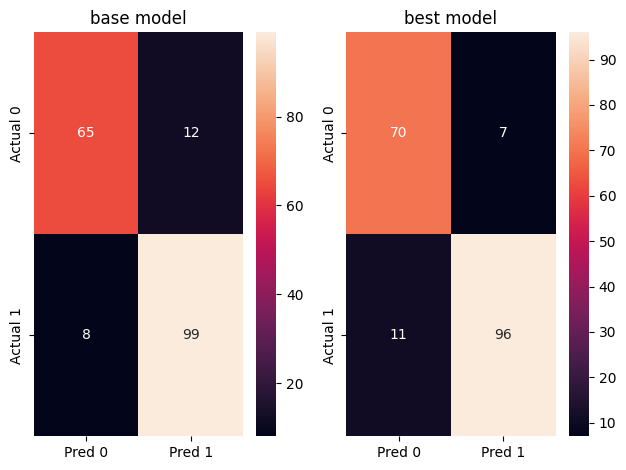

In [199]:
plt.subplot(1,2,1)
sns.heatmap(cm_base,annot=True,fmt='d')
plt.title('base model')
plt.subplot(1,2,2)
sns.heatmap(cm_best,annot=True,fmt='d')
plt.title('best model')
plt.tight_layout()